In [59]:
import sdepy
import numpy as np

@sdepy.integrate
def my_process(t, x, theta=1., k=1., sigma=1.):
    return {'dt': k*(theta - x), 'dw': sigma}

x = my_process(x0=1, paths=100*1000, steps=100)


In [60]:
timeline = np.linspace(0., 1., 5)
x(timeline)
timeline

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [61]:
import yfinance as yf

def check_stock_symbol(symbol):
    try:
        stock = yf.Ticker(symbol)
        info = stock.info
        # If the API returns a name, we assume the symbol is valid
        if 'shortName' in info:
            return f"{symbol} is a valid stock symbol: {info['shortName']}"
        else:
            return f"{symbol} is not a valid stock symbol"
    except Exception as e:
        return f"Error checking {symbol}: {e}"


In [62]:
ALPHAVANTAGE_API = 'S09O7OIWCQWSMDGQ'
import requests
import json
import pandas as pd

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
def get_stocks_data(symbol, data):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&month={data}&interval=1min&apikey={ALPHAVANTAGE_API}'
    r = requests.get(url)
    data = r.json()["Time Series (1min)"]
    print(data)
    df = pd.DataFrame([data[elem] for elem in data])
    df.rename(columns={
        '1. open': 'Open',
        '2. high': 'High',
        '3. low': 'Low',
        '4. close': 'Close',
        '5. volume': 'Volume'
    }, inplace=True)
    df['Open'] = df['Open'].astype(float)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df['Close'] = df['Close'].astype(float)
    df['Volume'] = df['Volume'].astype(int)

    df['Date'] = data.keys()
    df.set_index('Date', inplace=True)
    df.index = pd.to_datetime(df.index)
    return(df)

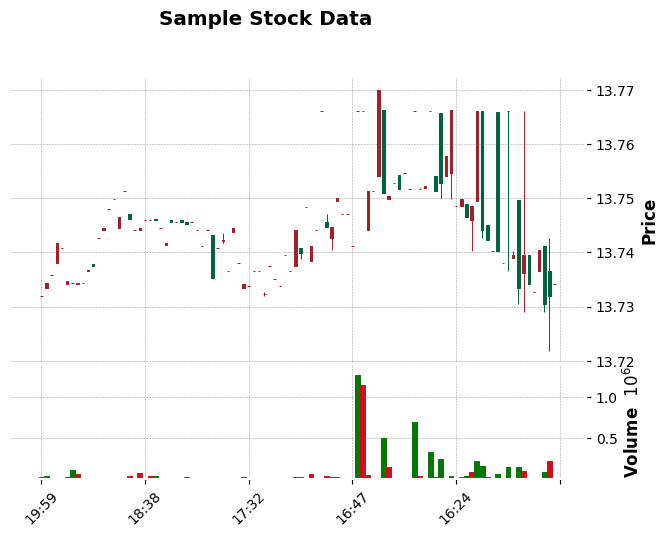

In [52]:
import mplfinance as mpf
mpf.plot(df, type='candle', style='charles', volume=True, title='Sample Stock Data', ylabel='Price')


In [54]:
check_stock_symbol('JAZZ')

'JAZZ is a valid stock symbol: Jazz Pharmaceuticals plc'